# Load

In [11]:
import pandas as pd
import numpy as np
from joblib import load
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import load_model
import joblib
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("Libraries loaded successfully.")

Libraries loaded successfully.


In [12]:
# --- Configuration ---
SEQUENCE_LENGTH = 30 # This should match the sequence length used during autoencoder training

# Anomaly score thresholds for classification (these are optimized values)
#crit_thresh = 3.277077
#warn_thresh = 1.464656
crit_thresh = 1.194757
warn_thresh = 0.807623

# Define numerical columns used for the autoencoder
numerical_cols = [
    'soil_mean', 'rain_mean', 'temp_mean', 'humi_mean', 'geo_mean'
]
# Define the order of labels for consistent evaluation and plotting
label_order = ['Critical', 'Warning', 'Normal']

# --- Load LSTM Autoencoder model and scaler ---
try:
    scaler = joblib.load('scaler2.save')
    model = load_model('lstm_autoencoder_model2.h5', compile=False) # compile=False since we're not retraining
    print("LSTM Autoencoder model and scaler loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    print("Make sure 'scaler.save' and 'lstm_autoencoder_model.h5' are in the correct directory.")
    exit() # Exit if essential files are missing
except Exception as e:
    print(f"An unexpected error occurred during model loading: {e}")
    exit() # Exit for other loading errors

LSTM Autoencoder model and scaler loaded successfully.


In [13]:
# --- Load and Preprocess Validation Data ---
df1 = pd.read_csv("./../../data/dev101_resample10T_flex.csv")
df2 = pd.read_csv("./../../data/dev102_resample10T_flex.csv")

# Concatenate dataframes and preprocess timestamps
df_val_raw = pd.concat([df1, df2], ignore_index=True)
df_val_raw['timestamp'] = pd.to_datetime(df_val_raw['timestamp'])
df_val_raw = df_val_raw.sort_values('timestamp').reset_index(drop=True)

# Fill missing 'label' values with 'Normal'
df_val_raw['label'] = df_val_raw['label'].fillna('Normal')

print(f"\nLoaded {len(df_val_raw)} data points from validation dataset.")
print("\nOriginal Label Distribution:")
print(df_val_raw['label'].value_counts())
print("\nDataFrame Description:")
print(df_val_raw.describe())

# Check for missing numerical columns
if not all(col in df_val_raw.columns for col in numerical_cols):
    missing_cols = [col for col in numerical_cols if col not in df_val_raw.columns]
    print(f"Error: Missing numerical columns in DataFrame: {missing_cols}")
    print("Please check your CSV files and 'numerical_cols' definition.")
    exit()

# Scale the numerical features using the loaded scaler
X_val_scaled = scaler.transform(df_val_raw[numerical_cols])

# Create a copy for sequence creation with scaled features
df_val_scaled_for_sequences = df_val_raw.copy()
for i, col in enumerate(numerical_cols):
    df_val_scaled_for_sequences[f'scaled_{col}'] = X_val_scaled[:, i]

print("\nData preprocessing complete.")


Loaded 6521 data points from validation dataset.

Original Label Distribution:
label
Normal      6473
warning       31
critical      17
Name: count, dtype: int64

DataFrame Description:
                           timestamp        devID    soil_mean    rain_mean  \
count                           6521  6521.000000  6521.000000  6521.000000   
mean   2025-06-05 03:49:52.455144704   101.511578    48.180404     0.205722   
min              2025-05-02 11:40:00   101.000000    21.105770     0.000000   
25%              2025-05-29 14:10:00   101.000000    42.900002     0.000000   
50%              2025-06-11 08:10:00   102.000000    49.646154     0.000000   
75%              2025-06-18 12:50:00   102.000000    57.420833     0.000000   
max              2025-06-29 20:20:00   102.000000    66.341464    34.802064   
std                              NaN     0.499904    10.641132     1.704438   

         temp_mean    humi_mean     geo_mean      geo_std         hour  \
count  6521.000000  6521.00

In [14]:
# --- Create Sequences and Calculate Anomaly Scores for LSTM Autoencoder ---
def create_sequences_by_device(df, sequence_length, numerical_cols, dev_ids=None, return_index=False):
    """
    สร้าง sequence สำหรับแต่ละ device (devID)
    Args:
        df: DataFrame ที่เตรียมข้อมูลแล้ว
        sequence_length: ความยาว sequence
        numerical_cols: รายชื่อคอลัมน์ feature
        dev_ids: รายชื่อ devID ที่ต้องการ (None = ทุก devID)
        return_index: คืนค่า original index ของแถวสุดท้ายในแต่ละ sequence หรือไม่
    Returns:
        sequences: np.array (num_seq, seq_len, num_feat)
        device_ids: รายชื่อ devID ของแต่ละ sequence
        timestamps: timestamp สุดท้ายของแต่ละ sequence
        (option) last_indices: index ของแถวสุดท้ายในแต่ละ sequence (ใน df)
    """
    sequences = []
    device_ids = []
    timestamps = []
    last_indices = []
    groupby_obj = df.groupby('devID')
    for dev_id, group in groupby_obj:
        if dev_ids is not None and dev_id not in dev_ids:
            continue
        group = group.sort_values('timestamp')
        values = group[[f'scaled_{col}' for col in numerical_cols]].values
        time_vals = group['timestamp'].values
        idx_vals = group.index.values
        for i in range(len(values) - sequence_length + 1):
            sequences.append(values[i:i + sequence_length])
            device_ids.append(dev_id)
            timestamps.append(time_vals[i + sequence_length - 1])
            if return_index:
                last_indices.append(idx_vals[i + sequence_length - 1])
    if return_index:
        return np.array(sequences), device_ids, timestamps, last_indices
    else:
        return np.array(sequences), device_ids, timestamps


print("\nCreating sequences and calculating anomaly scores for validation dataset...")

# Generate sequences from the scaled data
X_val_seq, val_device_ids, val_seq_timestamps, val_original_indices = \
    create_sequences_by_device(df_val_scaled_for_sequences, SEQUENCE_LENGTH, numerical_cols, return_index=True)

if len(X_val_seq) == 0:
    print("Error: No sequences formed from the validation dataset. Check SEQUENCE_LENGTH or data.")
    exit()

# Get reconstructed sequences from the autoencoder
reconstructed_sequences_val = model.predict(X_val_seq, verbose=0) # verbose=0 for quiet prediction

# Calculate anomaly score (Mean Squared Error between original and reconstructed sequences)
df_seq_results = pd.DataFrame({
    'devID': val_device_ids,
    'timestamp': val_seq_timestamps,
    'original_index': val_original_indices,
    'anomaly_score': np.mean(np.square(X_val_seq - reconstructed_sequences_val), axis=(1, 2))
})
print("Anomaly scores calculated.")


Creating sequences and calculating anomaly scores for validation dataset...
Anomaly scores calculated.


In [15]:
# --- Define Classification Function ---
def classify_risk(score):
    """
    Classifies an anomaly score into Critical, Warning, or Normal based on predefined thresholds.
    """
    if score > crit_thresh:
        return "Critical"
    elif score > warn_thresh:
        return "Warning"
    else:
        return "Normal"

print("\nRisk classification function defined.")


Risk classification function defined.


In [16]:
# --- Function to Evaluate for a Given Prediction Horizon ---
def evaluate_with_horizon(df_base, df_seq_results, prediction_horizon, numerical_cols, label_order, crit_thresh, warn_thresh):
    """
    Performs shifting of true labels and returns evaluation metrics for a given prediction horizon.
    - prediction_horizon (int): The number of rows/timestamps into the future for which the current anomaly score
                                is attempting to predict the true label.
                                e.g., if prediction_horizon = 10, anomaly_score at T predicts true_label at T+10.
    """
    df_temp = df_base.copy()

    # Merge anomaly scores back to df_temp based on original_index
    # The 'anomaly_score' corresponds to the end of a sequence (at original_index)
    df_temp = df_temp.merge(df_seq_results[['original_index', 'anomaly_score']],
                            left_index=True, right_on='original_index', how='left')
    df_temp.drop(columns=['original_index'], inplace=True)

    # Classify initial predicted risk based on the anomaly score at its calculated timestamp
    df_temp['predicted_risk_at_current_time'] = df_temp['anomaly_score'].apply(classify_risk)

    # Map true labels to the desired order
    df_temp['true_label_original'] = df_temp['label'].replace({
        'critical': 'Critical', 'normal': 'Normal', 'Normal': 'Normal', 'warning': 'Warning'
    })

    # --- Apply the Prediction Horizon Shift ---
    # To compare anomaly_score at time T with true_label at time T + prediction_horizon,
    # we need to shift the 'true_label_original' column backwards by 'prediction_horizon'.
    # This means true_label_shifted[i] will contain true_label_original[i + prediction_horizon].
    df_temp['true_label_shifted'] = df_temp.groupby('devID')['true_label_original'].shift(-prediction_horizon)

    # The anomaly score used for prediction is simply the one at the current timestamp (not shifted)
    df_temp['anomaly_score_for_prediction'] = df_temp['anomaly_score']

    # Drop rows where shifted true_label or anomaly_score_for_prediction is NaN
    # (occurs at the end of groups due to shifting, or if anomaly score wasn't calculated for a row)
    df_eval_filtered = df_temp.dropna(subset=['anomaly_score_for_prediction', 'true_label_shifted']).copy()

    # Filter to only include labels relevant to our analysis (Normal, Warning, Critical)
    df_eval_filtered = df_eval_filtered[df_eval_filtered['true_label_shifted'].isin(label_order)].copy()

    # Apply risk classification to the anomaly scores used for this shifted prediction
    df_eval_filtered['predicted_risk_for_horizon'] = df_eval_filtered['anomaly_score_for_prediction'].apply(classify_risk)

    y_true_for_horizon = df_eval_filtered['true_label_shifted']
    y_pred_for_horizon = df_eval_filtered['predicted_risk_for_horizon']

    # Handle cases where a specific label might be missing from y_true or y_pred
    # This ensures consistency for classification_report and confusion_matrix
    present_labels = sorted(list(set(y_true_for_horizon.unique()).union(set(y_pred_for_horizon.unique()))))
    # Filter label_order to only include labels actually present in the current evaluation subset
    current_labels_in_order_for_metrics = [label for label in label_order if label in present_labels]

    if len(y_true_for_horizon) == 0 or len(y_pred_for_horizon) == 0:
        return {
            'horizon': prediction_horizon,
            'f1_weighted': 0.0,
            'f1_macro': 0.0,
            'f1_per_class': {label: 0.0 for label in label_order},
            'report': "No data for this horizon.",
            'confusion_matrix': np.zeros((len(label_order), len(label_order))),
            'df_filtered': pd.DataFrame() # Return empty DataFrame
        }

    # Calculate F1-scores
    f1_weighted = f1_score(y_true_for_horizon, y_pred_for_horizon, average='weighted', labels=current_labels_in_order_for_metrics, zero_division=0)
    f1_macro = f1_score(y_true_for_horizon, y_pred_for_horizon, average='macro', labels=current_labels_in_order_for_metrics, zero_division=0)
    f1_per_class = f1_score(y_true_for_horizon, y_pred_for_horizon, average=None, labels=current_labels_in_order_for_metrics, zero_division=0)
    
    f1_per_class_dict = {current_labels_in_order_for_metrics[i]: f1_per_class[i] for i in range(len(current_labels_in_order_for_metrics))}
    # Fill in 0 for classes not present in this specific evaluation subset but in original label_order
    for lbl in label_order:
        if lbl not in f1_per_class_dict:
            f1_per_class_dict[lbl] = 0.0

    report = classification_report(y_true_for_horizon, y_pred_for_horizon, labels=current_labels_in_order_for_metrics, target_names=current_labels_in_order_for_metrics, zero_division=0)
    cm = confusion_matrix(y_true_for_horizon, y_pred_for_horizon, labels=current_labels_in_order_for_metrics)
    
    # Pad confusion matrix to full label_order size if current_labels_in_order_for_metrics is smaller
    full_cm = np.zeros((len(label_order), len(label_order)), dtype=int)
    for i, true_lbl in enumerate(current_labels_in_order_for_metrics):
        true_idx = label_order.index(true_lbl)
        for j, pred_lbl in enumerate(current_labels_in_order_for_metrics):
            pred_idx = label_order.index(pred_lbl)
            full_cm[true_idx, pred_idx] = cm[i, j]

    return {
        'horizon': prediction_horizon,
        'f1_weighted': f1_weighted,
        'f1_macro': f1_macro,
        'f1_per_class': f1_per_class_dict,
        'report': report,
        'confusion_matrix': full_cm,
        'y_true': y_true_for_horizon,
        'y_pred': y_pred_for_horizon,
        'df_filtered': df_eval_filtered # Return the filtered DataFrame for plotting later
    }

print("\nEvaluation function 'evaluate_with_horizon' defined.")


Evaluation function 'evaluate_with_horizon' defined.


# Find Delay and F1-score


--- Searching for Optimal Prediction Horizon (0 to 30 rows) ---

Evaluating with Prediction Horizon = -50 rows...
  Weighted F1-score: 0.9743
  Macro F1-score: 0.3272
  F1-score per class:
    Critical: 0.0000
    Normal: 0.9817

Evaluating with Prediction Horizon = -49 rows...
  Weighted F1-score: 0.9744
  Macro F1-score: 0.3272
  F1-score per class:
    Critical: 0.0000
    Normal: 0.9817

Evaluating with Prediction Horizon = -48 rows...
  Weighted F1-score: 0.9744
  Macro F1-score: 0.3272
  F1-score per class:
    Critical: 0.0000
    Normal: 0.9817

Evaluating with Prediction Horizon = -47 rows...
  Weighted F1-score: 0.9744
  Macro F1-score: 0.3272
  F1-score per class:
    Critical: 0.0000
    Normal: 0.9817

Evaluating with Prediction Horizon = -46 rows...
  Weighted F1-score: 0.9744
  Macro F1-score: 0.3272
  F1-score per class:
    Critical: 0.0000
    Normal: 0.9817

Evaluating with Prediction Horizon = -45 rows...
  Weighted F1-score: 0.9744
  Macro F1-score: 0.3272
  F1-sc

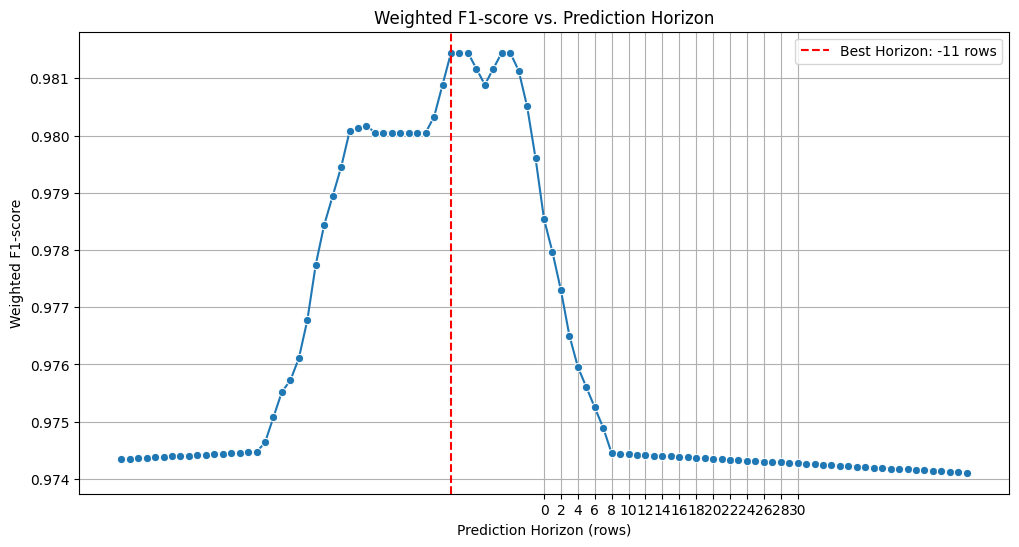

In [17]:
# --- Loop to Find Optimal Prediction Horizon ---
best_f1_weighted = -1
best_horizon = 0
results_per_horizon = [] # To store detailed results for each horizon
best_horizon_data = None # To store data for plotting the best performing horizon

print("\n--- Searching for Optimal Prediction Horizon (0 to 30 rows) ---")

for horizon in range(-50, 51): 
    print(f"\nEvaluating with Prediction Horizon = {horizon} rows...")
    
    current_results = evaluate_with_horizon(
        df_base=df_val_raw, # Use the original raw DataFrame as the base
        df_seq_results=df_seq_results, # Use the calculated anomaly scores
        prediction_horizon=horizon,
        numerical_cols=numerical_cols,
        label_order=label_order,
        crit_thresh=crit_thresh,
        warn_thresh=warn_thresh
    )
    
    results_per_horizon.append(current_results) # Store all results

    print(f"  Weighted F1-score: {current_results['f1_weighted']:.4f}")
    print(f"  Macro F1-score: {current_results['f1_macro']:.4f}")
    print("  F1-score per class:")
    for label, score in current_results['f1_per_class'].items():
        print(f"    {label}: {score:.4f}")

    if current_results['f1_weighted'] > best_f1_weighted:
        best_f1_weighted = current_results['f1_weighted']
        best_horizon = horizon
        best_horizon_data = current_results # Store the full result dictionary for the best horizon

print(f"\n--- Optimal Prediction Horizon Results ---")
print(f"Best Weighted F1-score: {best_f1_weighted:.4f} at Prediction Horizon: {best_horizon} rows")

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame([
    {
        'Horizon': r['horizon'],
        'F1_Weighted': r['f1_weighted'],
        'F1_Macro': r['f1_macro'],
        'F1_Critical': r['f1_per_class'].get('Critical', 0.0),
        'F1_Warning': r['f1_per_class'].get('Warning', 0.0),
        'F1_Normal': r['f1_per_class'].get('Normal', 0.0),
    } for r in results_per_horizon
])
print("\nF1-scores across different prediction horizons:")
print(results_df.set_index('Horizon').round(4))

# Plot F1-weighted score across horizons
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x='Horizon', y='F1_Weighted', marker='o')
plt.title('Weighted F1-score vs. Prediction Horizon')
plt.xlabel('Prediction Horizon (rows)')
plt.ylabel('Weighted F1-score')
plt.xticks(range(0, 31, 2)) # Show ticks every 2 units
plt.grid(True)
plt.axvline(x=best_horizon, color='r', linestyle='--', label=f'Best Horizon: {best_horizon} rows')
plt.legend()
plt.show()

In [18]:
df_val_final_for_plotting = best_horizon_data['df_filtered']
y_true_final = best_horizon_data['y_true']
y_pred_final = best_horizon_data['y_pred']
final_horizon = best_horizon_data['horizon']
cm_final = best_horizon_data['confusion_matrix'] # Already padded to full label_order size
print(f"\n--- Detailed Evaluation for Optimal Prediction Horizon ({final_horizon} rows) ---")

print("\nPredicted Risk Distribution (at optimal horizon):")
print(y_pred_final.value_counts())

print("\nTrue Label Distribution (at optimal horizon):")
print(y_true_final.value_counts())
print("\nClassification Report (at optimal horizon):")
print(classification_report(y_true_final, y_pred_final, labels=label_order, target_names=label_order, zero_division=0))
print("\nConfusion Matrix (at optimal horizon):")
print(cm_final)


--- Detailed Evaluation for Optimal Prediction Horizon (-11 rows) ---

Predicted Risk Distribution (at optimal horizon):
predicted_risk_for_horizon
Normal      6280
Critical     136
Warning       47
Name: count, dtype: int64

True Label Distribution (at optimal horizon):
true_label_shifted
Normal      6415
Warning       31
Critical      17
Name: count, dtype: int64

Classification Report (at optimal horizon):
              precision    recall  f1-score   support

    Critical       0.09      0.71      0.16        17
     Warning       0.13      0.19      0.15        31
      Normal       1.00      0.98      0.99      6415

    accuracy                           0.97      6463
   macro avg       0.40      0.63      0.43      6463
weighted avg       0.99      0.97      0.98      6463


Confusion Matrix (at optimal horizon):
[[  12    3    2]
 [  16    6    9]
 [ 108   38 6269]]


# F1-score

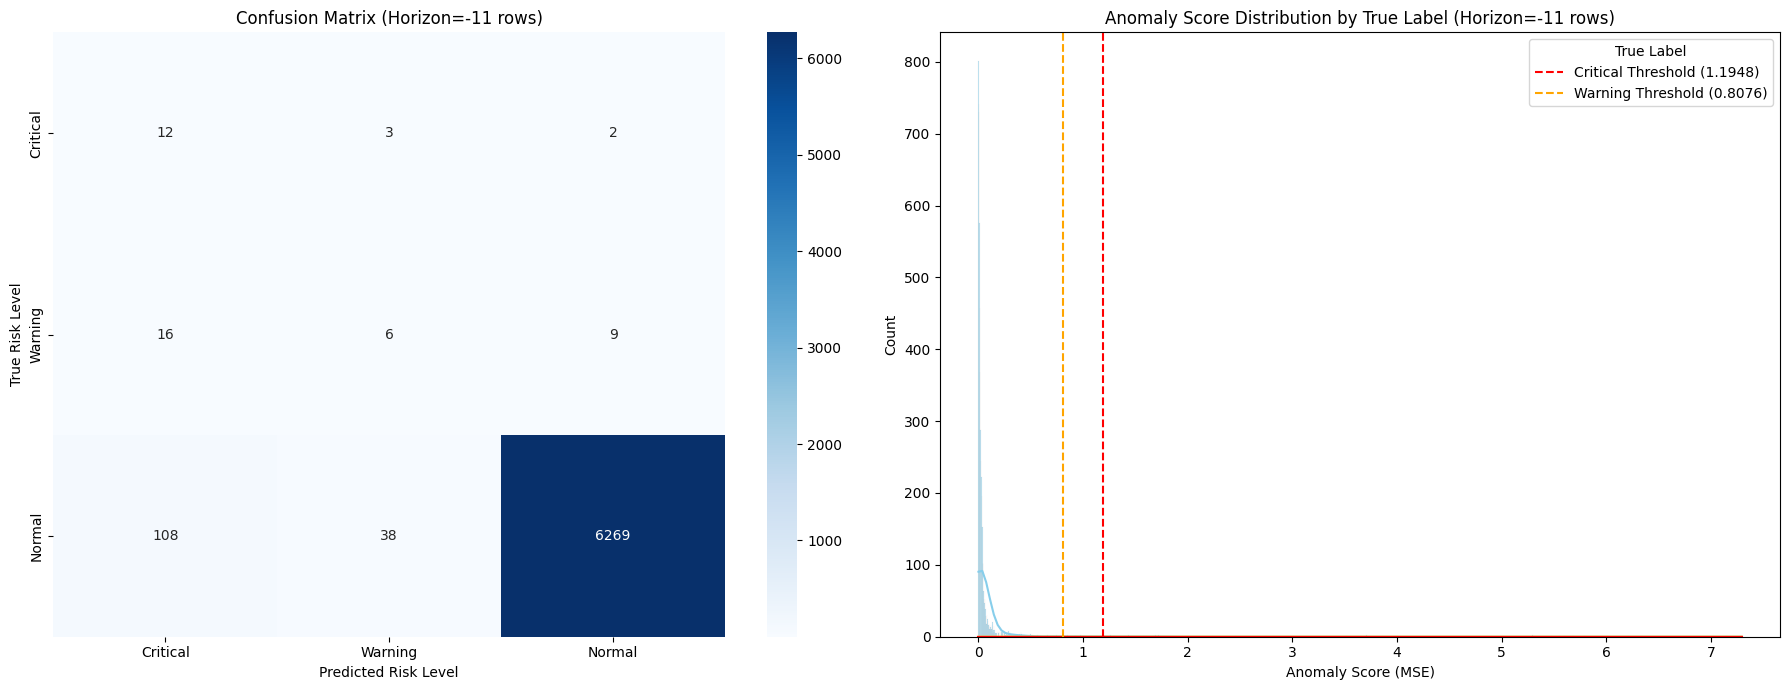

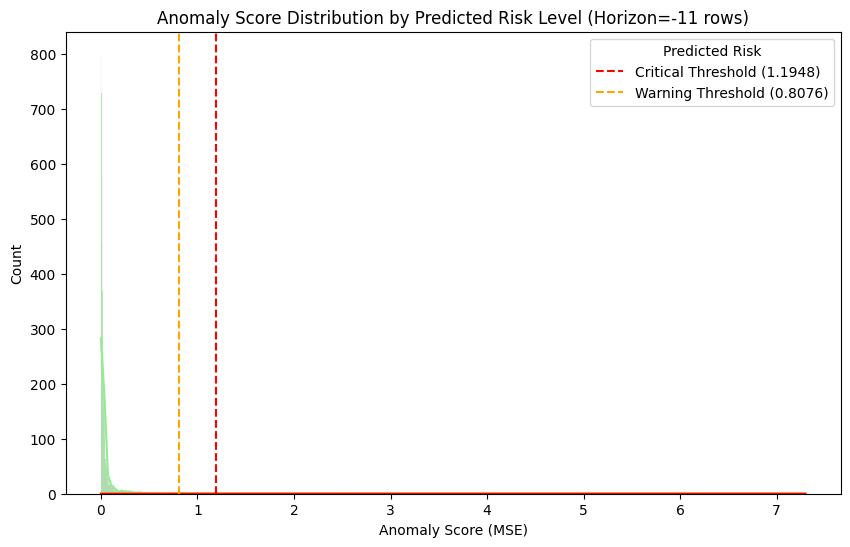

In [19]:
# --- Combined Classification Report & Anomaly Score Distribution Plot ---
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
# Plot 1: Confusion Matrix
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_order,
            yticklabels=label_order, ax=axes[0])
axes[0].set_title(f'Confusion Matrix (Horizon={final_horizon} rows)')
axes[0].set_xlabel('Predicted Risk Level')
axes[0].set_ylabel('True Risk Level')

# Plot 2: Anomaly Score Distribution by True Label
sns.histplot(df_val_final_for_plotting, x='anomaly_score_for_prediction', hue='true_label_shifted', kde=True,
            palette={'Normal': 'skyblue', 'Critical': 'red', 'Warning': 'orange'},
            hue_order=label_order, ax=axes[1])
axes[1].axvline(x=crit_thresh, color='red', linestyle='--', label=f'Critical Threshold ({crit_thresh:.4f})')
axes[1].axvline(x=warn_thresh, color='orange', linestyle='--', label=f'Warning Threshold ({warn_thresh:.4f})')
axes[1].set_title(f'Anomaly Score Distribution by True Label (Horizon={final_horizon} rows)')
axes[1].set_xlabel('Anomaly Score (MSE)')
axes[1].set_ylabel('Count')
axes[1].legend(title='True Label')
plt.tight_layout()
plt.show()

# Additional Plot: Anomaly Score Distribution by Predicted Risk
plt.figure(figsize=(10, 6))
sns.histplot(df_val_final_for_plotting, x='anomaly_score_for_prediction', hue='predicted_risk_for_horizon', kde=True,
            palette={'Normal': 'lightgreen', 'Warning': 'gold', 'Critical': 'red'},
            hue_order=label_order)
plt.title(f'Anomaly Score Distribution by Predicted Risk Level (Horizon={final_horizon} rows)')
plt.xlabel('Anomaly Score (MSE)')
plt.ylabel('Count')
plt.axvline(x=crit_thresh, color='red', linestyle='--', label=f'Critical Threshold ({crit_thresh:.4f})')
plt.axvline(x=warn_thresh, color='orange', linestyle='--', label=f'Warning Threshold ({warn_thresh:.4f})')
plt.legend(title='Predicted Risk')
plt.show()

In [20]:

print(f"\n--- NUMERICAL METRICS for Optimal Horizon ({final_horizon} rows) ---")

# --- 1. Classification Report ---
print("\nClassification Report:")
# Ensure correct labels are passed to classification_report for accurate reporting
report_labels_actual = [label for label in label_order if label in y_true_final.unique() or label in y_pred_final.unique()]
print(classification_report(y_true_final, y_pred_final, labels=report_labels_actual, target_names=report_labels_actual, zero_division=0))

# --- 2. Confusion Matrix ---
print("\nConfusion Matrix:")
# Print the raw numpy array of the confusion matrix
print(cm_final)

# (Optional) For better readability, especially if you have many classes or complex matrix:
print("\nConfusion Matrix (DataFrame representation):")
cm_df = pd.DataFrame(cm_final, index=[f'True: {l}' for l in label_order], columns=[f'Pred: {l}' for l in label_order])
print(cm_df)



--- NUMERICAL METRICS for Optimal Horizon (-11 rows) ---

Classification Report:
              precision    recall  f1-score   support

    Critical       0.09      0.71      0.16        17
     Warning       0.13      0.19      0.15        31
      Normal       1.00      0.98      0.99      6415

    accuracy                           0.97      6463
   macro avg       0.40      0.63      0.43      6463
weighted avg       0.99      0.97      0.98      6463


Confusion Matrix:
[[  12    3    2]
 [  16    6    9]
 [ 108   38 6269]]

Confusion Matrix (DataFrame representation):
                Pred: Critical  Pred: Warning  Pred: Normal
True: Critical              12              3             2
True: Warning               16              6             9
True: Normal               108             38          6269
